In [4]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


Using TensorFlow backend.


In [5]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [6]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40


keras version  2.3.1


In [7]:
df = read_data('../Data/WISDM_ar_v1.1_raw.txt')
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [8]:
show_basic_dataframe_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332

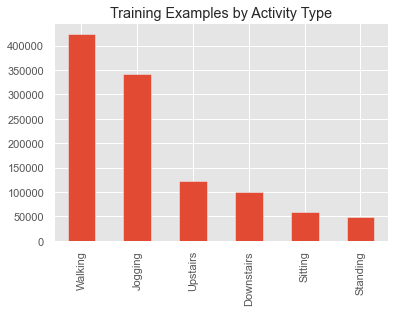

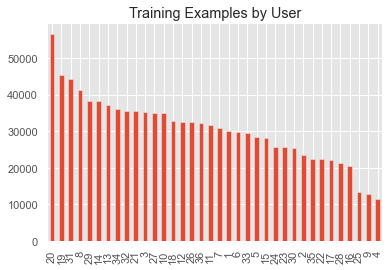

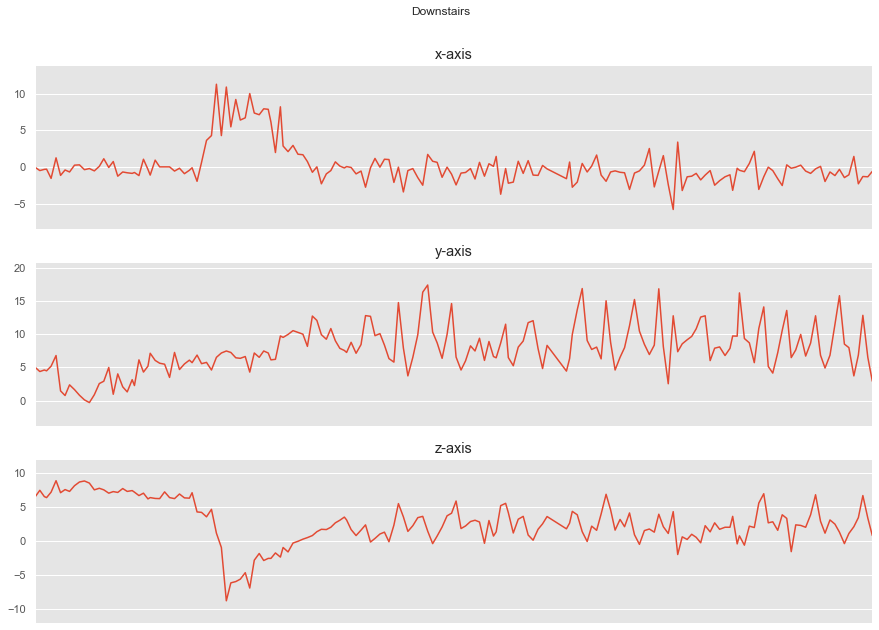

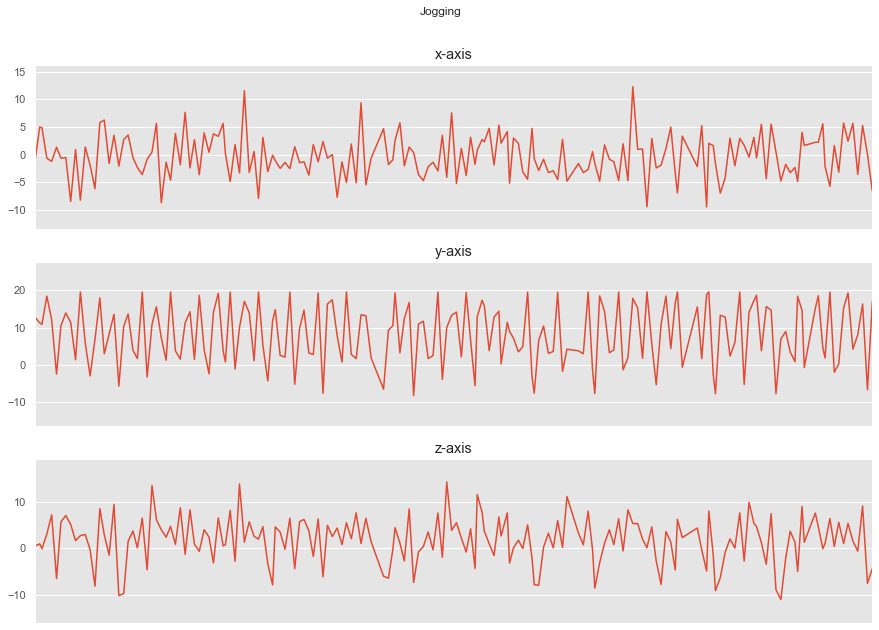

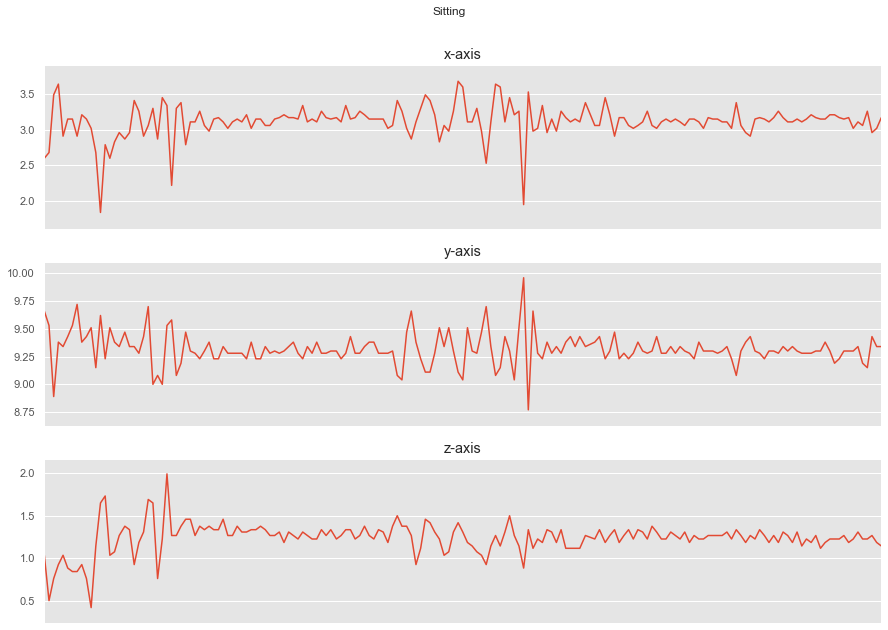

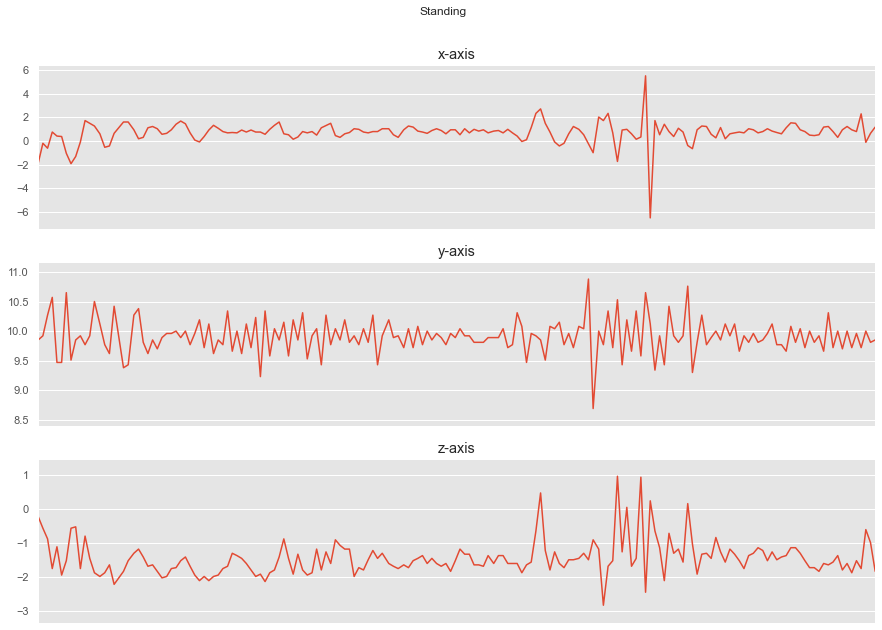

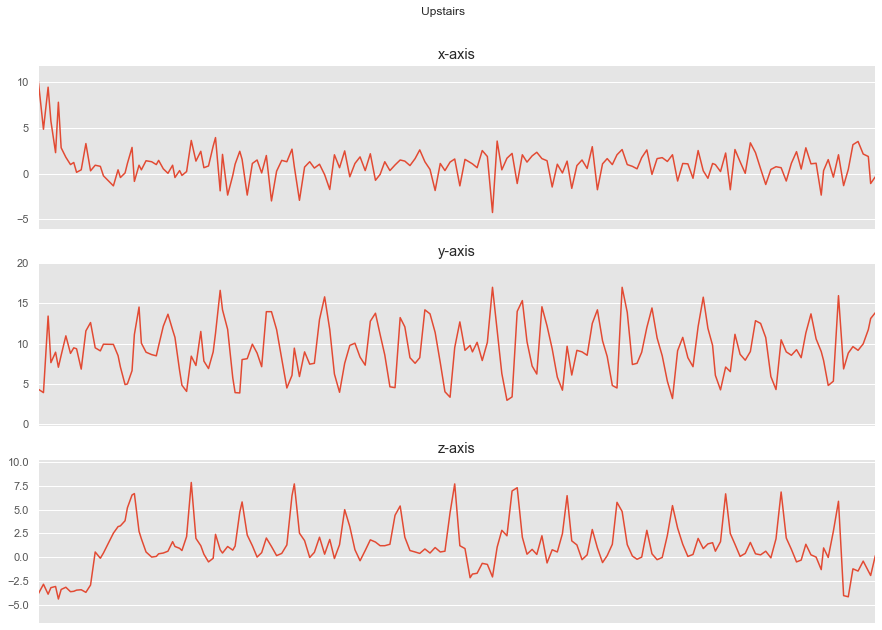

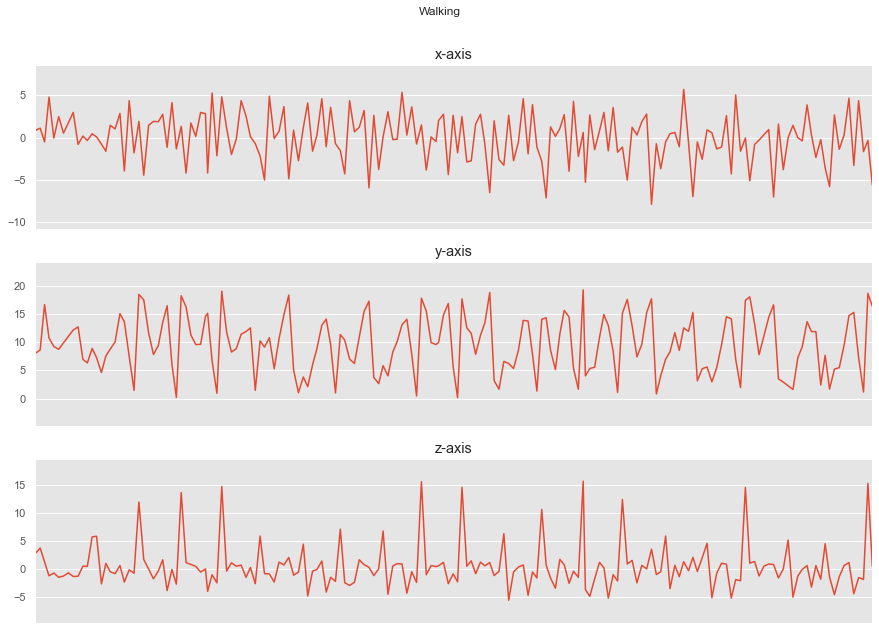

In [9]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [10]:
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


--- Reshape the data into segments ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [11]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)



--- Reshape data to be accepted by Keras ---

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 240)
input_shape: 240
New y_train shape:  (20868, 6)


In [12]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_p

In [13]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])



--- Fit the model ---



In [14]:
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 9s 551us/step - loss: 0.7709 - accuracy: 0.7137 - val_loss: 0.6753 - val_accuracy: 0.7758
Epoch 2/50
16694/16694 [==============================] - 10s 603us/step - loss: 0.3878 - accuracy: 0.8519 - val_loss: 0.6524 - val_accuracy: 0.7954
Epoch 3/50
16694/16694 [==============================] - 12s 696us/step - loss: 0.2528 - accuracy: 0.9110 - val_loss: 0.6149 - val_accuracy: 0.8251
Epoch 4/50
16694/16694 [==============================] - 9s 530us/step - loss: 0.1803 - accuracy: 0.9405 - val_loss: 0.6570 - val_accuracy: 0.8112
Epoch 5/50
16694/16694 [==============================] - 9s 532us/step - loss: 0.1638 - accuracy: 0.9468 - val_loss: 0.6689 - val_accuracy: 0.8014
Epoch 6/50
16694/16694 [==============================] - 11s 664us/step - loss: 0.1393 - accuracy: 0.9559 - val_loss: 0.6916 - val_accuracy: 0.7956
Epoch 7/50
16694/16694 [==============================] - 11

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


--- Learning curve of model training ---



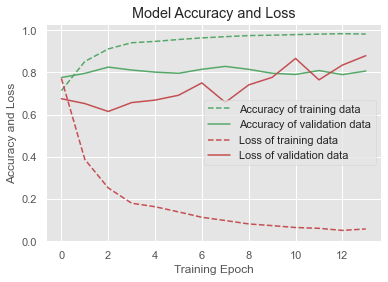

In [16]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [17]:
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])



--- Check against test data ---



/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

6584/6584 [==============================] - 1s 175us/step

Accuracy on test data: 0.92

Loss on test data: 0.43



--- Confusion matrix for test data ---



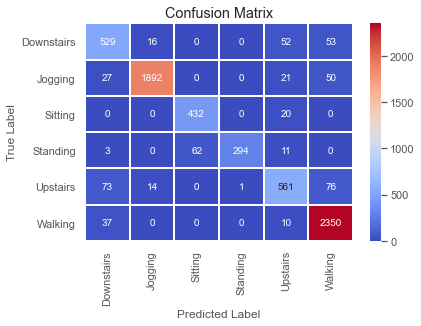

In [18]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [19]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       650
           1       0.98      0.95      0.97      1990
           2       0.87      0.96      0.91       452
           3       1.00      0.79      0.88       370
           4       0.83      0.77      0.80       725
           5       0.93      0.98      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584



In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1_score(max_y_test, max_y_pred_test,pos_label='positive',average='micro'),precision_score(max_y_test, max_y_pred_test,pos_label='positive',average='micro'),recall_score(max_y_test, max_y_pred_test,pos_label='positive',average='micro')

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


(0.9201093560145808, 0.9201093560145808, 0.9201093560145808)

In [2]:
print("""--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       650
           1       0.87      0.96      0.91      1990
           2       0.95      0.91      0.93       452
           3       0.90      0.94      0.92       370
           4       0.91      0.73      0.81       725
           5       0.94      0.90      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.90      0.90      0.90      6584""")

--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       650
           1       0.87      0.96      0.91      1990
           2       0.95      0.91      0.93       452
           3       0.90      0.94      0.92       370
           4       0.91      0.73      0.81       725
           5       0.94      0.90      0.92      2397

    accuracy                           0.90      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.90      0.90      0.90      6584


In [3]:
print("""--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       523
           1       0.95      0.97      0.96      1589
           2       0.85      0.99      0.92       361
           3       0.99      0.77      0.87       297
           4       0.93      0.72      0.81       579
           5       0.92      0.98      0.95      1918

    accuracy                           0.92      5267
   macro avg       0.91      0.87      0.88      5267
weighted avg       0.92      0.92      0.91      5267""")

--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       523
           1       0.95      0.97      0.96      1589
           2       0.85      0.99      0.92       361
           3       0.99      0.77      0.87       297
           4       0.93      0.72      0.81       579
           5       0.92      0.98      0.95      1918

    accuracy                           0.92      5267
   macro avg       0.91      0.87      0.88      5267
weighted avg       0.92      0.92      0.91      5267


In [38]:
df_test.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.3,0.8,0.1,1
1,33,Jogging,49106062271000,0.6,0.6,0.2,1
2,33,Jogging,49106112167000,0.6,0.5,-0.1,1
3,33,Jogging,49106222305000,-0.3,1.7,0.6,1
4,33,Jogging,49106332290000,-0.4,0.7,1.6,1


In [36]:
df_v2 = read_data('../Data/WISDM_at_v2.0_raw.txt')
df_v2.shape

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(2980765, 6)

In [28]:
show_basic_dataframe_info(df_v2, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 2980765

First 20 rows of the dataframe:

    user-id activity      timestamp  x-axis  y-axis  z-axis
0      1679  Walking  1370520469556     0.3    -0.6    -0.2
1      1679  Walking  1370520469606    -0.5    -0.6    -0.2
2      1679  Walking  1370520469656    -2.2     0.7     0.4
3      1679  Walking  1370520469706    -2.8     1.4    -0.3
4      1679  Walking  1370520469756    -2.2    -1.3    -0.6
5      1679  Walking  1370520469806    -1.7     0.8    -0.2
6      1679  Walking  1370520469856    -1.5     0.8     0.4
7      1679  Walking  1370520469906    -0.9     1.1     0.4
8      1679  Walking  1370520469956     0.2     0.3     0.5
9      1679  Walking  1370520470006     0.9     0.1     0.6
10     1679  Walking  1370520470056     1.7    -0.9     0.7
11     1679  Walking  1370520470106     1.4    -1.3     0.4
12     1679  Walking  1370520470156    -1.2     0.9    -0.1
13     1679  Walking  1370520470206    -0.3    

In [29]:
df_v2['x-axis'] = feature_normalize(df_v2['x-axis'])
df_v2['y-axis'] = feature_normalize(df_v2['y-axis'])
df_v2['z-axis'] = feature_normalize(df_v2['z-axis'])
df_v2 = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test_v2, y_test_v2 = create_segments_and_labels(df_v2,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test_v2 = x_test_v2.reshape(x_test_v2.shape[0], input_shape)

x_test_v2 = x_test_v2.astype("float32")
y_test_v2 = y_test_v2.astype("float32")

y_test_v2 = np_utils.to_categorical(y_test_v2, num_classes)

score = model_m.evaluate(x_test_v2, y_test_v2, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

6584/6584 [==============================] - 2s 335us/step

Accuracy on test data: 0.91

Loss on test data: 0.87


In [30]:
df_v2.shape

(263423, 7)

In [31]:
x_test_v2.shape

(6584, 240)

In [32]:
x_test.shape

(6584, 240)

In [33]:
input_shape

240

In [40]:
df_test.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.3,0.8,0.1,1
1,33,Jogging,49106062271000,0.6,0.6,0.2,1
2,33,Jogging,49106112167000,0.6,0.5,-0.1,1
3,33,Jogging,49106222305000,-0.3,1.7,0.6,1
4,33,Jogging,49106332290000,-0.4,0.7,1.6,1


In [41]:
df_v2.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,1679,Walking,1370520469556,0.3,-0.6,-0.2
1,1679,Walking,1370520469606,-0.5,-0.6,-0.2
2,1679,Walking,1370520469656,-2.2,0.7,0.4
3,1679,Walking,1370520469706,-2.8,1.4,-0.3
4,1679,Walking,1370520469756,-2.2,-1.3,-0.6


In [42]:
df_v2[LABEL] = le.fit_transform(df_v2["activity"].values.ravel())

In [43]:
df_v2.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,1679,Walking,1370520469556,0.3,-0.6,-0.2,5
1,1679,Walking,1370520469606,-0.5,-0.6,-0.2,5
2,1679,Walking,1370520469656,-2.2,0.7,0.4,5
3,1679,Walking,1370520469706,-2.8,1.4,-0.3,5
4,1679,Walking,1370520469756,-2.2,-1.3,-0.6,5


In [44]:
df_v2['x-axis'] = feature_normalize(df_v2['x-axis'])
df_v2['y-axis'] = feature_normalize(df_v2['y-axis'])
df_v2['z-axis'] = feature_normalize(df_v2['z-axis'])
df_v2 = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test_v2, y_test_v2 = create_segments_and_labels(df_v2,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test_v2 = x_test_v2.reshape(x_test_v2.shape[0], input_shape)

x_test_v2 = x_test_v2.astype("float32")
y_test_v2 = y_test_v2.astype("float32")

y_test_v2 = np_utils.to_categorical(y_test_v2, num_classes)

score = model_m.evaluate(x_test_v2, y_test_v2, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

6584/6584 [==============================] - 1s 190us/step

Accuracy on test data: 0.91

Loss on test data: 0.87


In [46]:
x_test_v2

array([[-0.318667,  0.586725,  0.569438, ...,  0.209134, -0.648489,
         1.833785],
       [ 0.690445, -0.17173 , -0.973402, ...,  0.124579,  1.731112,
        -0.129084],
       [-0.141478, -0.774604, -0.949632, ...,  1.60428 , -2.022497,
        -2.490566],
       ...,
       [ 0.88462 ,  0.806883,  1.019471, ..., -0.155386, -0.104392,
        -0.062266],
       [ 0.867169,  0.817988,  0.921109, ..., -0.197511, -0.137649,
         0.066327],
       [ 1.128938,  1.019471,  0.989328, ...,  0.345684,  0.208222,
         0.157229]], dtype=float32)

In [47]:
x_test

array([[-0.318667,  0.586725,  0.569438, ...,  0.209134, -0.648489,
         1.833785],
       [ 0.690445, -0.17173 , -0.973402, ...,  0.124579,  1.731112,
        -0.129084],
       [-0.141478, -0.774604, -0.949632, ...,  1.60428 , -2.022497,
        -2.490566],
       ...,
       [ 0.88462 ,  0.806883,  1.019471, ..., -0.155386, -0.104392,
        -0.062266],
       [ 0.867169,  0.817988,  0.921109, ..., -0.197511, -0.137649,
         0.066327],
       [ 1.128938,  1.019471,  0.989328, ...,  0.345684,  0.208222,
         0.157229]], dtype=float32)

In [46]:
import pickle 

with open('X and Y Dataset/x_test.pickle','wb') as fd:
    # datasetObj = {"x_test":x_test,"y_test":y_test,"x_train":x_train,"y_train":y_train}
    pickle.dump(x_test,fd)

with open('X and Y Dataset/y_test.pickle','wb') as fd:
    pickle.dump(y_test,fd)

with open('X and Y Dataset/x_train.pickle','wb') as fd:
    pickle.dump(x_train,fd)

with open('X and Y Dataset/y_train.pickle','wb') as fd:
    pickle.dump(y_train,fd)

with open('X and Y Dataset/properties.pickle','wb') as fd:
    pickle.dump([num_time_periods, num_sensors,num_classes,input_shape],fd)
